<p style="font-size: 20px; margin-bottom: 3px; margin-top: 3px;">By: Ayushman Anupam</p>  
<p style="font-size: 20px; margin-top: 3px;">GitHub Link: <a href="https://github.com/AyushmanGHub">https://github.com/AyushmanGHub</a></p>

<div style="text-align: center;">
  <span style="color: #4A90E2; font-size: 40px; font-weight: bold;">CreditRisk - Predicting Borrower Reliability</span>
  <hr style="border: 1px dashed grey; width: 80%;"/>
</div>


<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:35px; font-weight: bold;">Importing needed Libraries</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from IPython.display import display

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.inspection import permutation_importance

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:35px; font-weight: bold;">Importing Dataset and Preprocessing</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>


In [12]:
# DataSource - https://www.kaggle.com/datasets/pradip11/amexpert-codelab-2021
df = pd.read_csv(r"Dataset.csv")

In [13]:
df.isnull().sum().sort_values(ascending=False)

no_of_children             774
owns_car                   547
no_of_days_employed        463
yearly_debt_payments        95
migrant_worker              87
total_family_members        83
credit_score                 8
customer_id                  0
default_in_last_6months      0
prev_defaults                0
credit_limit_used(%)         0
credit_limit                 0
occupation_type              0
name                         0
net_yearly_income            0
owns_house                   0
gender                       0
age                          0
credit_card_default          0
dtype: int64

In [14]:
df_filtered = df.dropna()
df_filtered = df_filtered[df_filtered["gender"] != "XNA"]
rows_with_missing_values = df[df.isnull().any(axis=1)].shape[0]

print(f"Total number of rows with missing values: {rows_with_missing_values + 1}")
print(f"Shape of original DataFrame: {df.shape}")
print(f"Shape of filtered DataFrame: {df_filtered.shape}")


Total number of rows with missing values: 2020
Shape of original DataFrame: (45528, 19)
Shape of filtered DataFrame: (43508, 19)


In [15]:
df_filtered.isnull().sum()

customer_id                0
name                       0
age                        0
gender                     0
owns_car                   0
owns_house                 0
no_of_children             0
net_yearly_income          0
no_of_days_employed        0
occupation_type            0
total_family_members       0
migrant_worker             0
yearly_debt_payments       0
credit_limit               0
credit_limit_used(%)       0
credit_score               0
prev_defaults              0
default_in_last_6months    0
credit_card_default        0
dtype: int64

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:35px; font-weight: bold;">Exploratory Data Analysis</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>


In [16]:
categorical_features = [col for col in df.columns if df[col].dtypes == "object"]
numerical_features =  [col for col in df.columns if df[col].dtypes != "object"]

print("no of categorial features: ", len(categorical_features))
print("Categorical features are", categorical_features)
print("no of Numerical features: ", len(numerical_features))
print("Numerical features are", numerical_features)

no of categorial features:  6
Categorical features are ['customer_id', 'name', 'gender', 'owns_car', 'owns_house', 'occupation_type']
no of Numerical features:  13
Numerical features are ['age', 'no_of_children', 'net_yearly_income', 'no_of_days_employed', 'total_family_members', 'migrant_worker', 'yearly_debt_payments', 'credit_limit', 'credit_limit_used(%)', 'credit_score', 'prev_defaults', 'default_in_last_6months', 'credit_card_default']


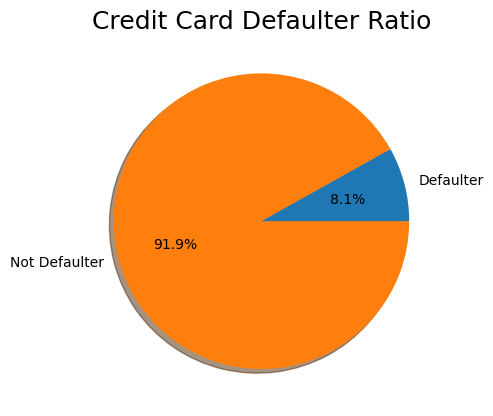

In [17]:
total_default_values = df_filtered.credit_card_default.value_counts(ascending=True).values

plt.figure()
plt.pie(total_default_values, labels=['Defaulter', 'Not Defaulter'], autopct='%1.1f%%', shadow=True)
plt.title('Credit Card Defaulter Ratio', fontsize=18)
plt.show()

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:35px; font-weight: bold;">Data Encoding, Splitting and Normalization</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>

In [18]:
df_filtered['owns_car'] = df_filtered['owns_car'].map({'Y': 1, 'N': 0})
df_filtered['owns_house'] = df_filtered['owns_house'].map({'Y': 1, 'N': 0})
df_filtered['gender'] = df_filtered['gender'].map({'M': 1, 'F': 0})
df_filtered['occupation_type'] = df_filtered['occupation_type'].astype('category').cat.codes

In [19]:
X = df_filtered.drop(columns=['credit_card_default', 'customer_id', 'name'])
y = df_filtered['credit_card_default']

X_train_unbalanced, X_test, y_train_unbalanced, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(sampling_strategy=0.8, random_state=42)  # Creates a 50-50 balance
X_train, y_train = smote.fit_resample(X_train_unbalanced, y_train_unbalanced)
print("Balanced class distribution:\n", y_train.value_counts())
print("Unbalanced class distribution:\n", y_train_unbalanced.value_counts())


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled= scaler.transform(X_test)

Balanced class distribution:
 credit_card_default
0    32014
1    25611
Name: count, dtype: int64
Unbalanced class distribution:
 credit_card_default
0    32014
1     2792
Name: count, dtype: int64


c:\Users\ayush\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\ayush\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\ayush\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ayush\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\ayush\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

<div style="text-align: center;">
  <span style="color: #FF0000; font-size:40px; font-weight: bold;">01. XGBoost Classifier</span>
  <hr style="border: 2px solid grey; width: 100%;"/>
</div>

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:30px; font-weight: bold;">Model Training and Feature selection</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>

In [20]:
xgb_model = xgb.XGBClassifier(random_state=2, max_depth = 5, eval_metric='mlogloss',eta = 0.01,enable_categorical = True)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eta=0.01, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [71]:
feature_importance_dict = xgb_model.get_booster().get_score(importance_type='weight')
all_features = X_train.columns

# Ensure all features are included in the importance dictionary, even if not used (set to 0 if not used)
for feature in all_features:
    if feature not in feature_importance_dict:
        feature_importance_dict[feature] = 0
xgb_model_feature_importance = list(feature_importance_dict.values())
xgb_model_feature_significance = pd.DataFrame({
    'Feature': X_train.columns if isinstance(X_train, pd.DataFrame) else [f"Feature_{i}" for i in range(X_train.shape[1])],  # Feature names
    'xgb_model_feature_significance': xgb_model_feature_importance 
})
xgb_model_feature_significance_sorted = xgb_model_feature_significance.sort_values(by='xgb_model_feature_significance', ascending=False)
xgb_model_feature_significance

,Feature,xgb_model_feature_significance
0,age,64.0
1,gender,109.0
2,owns_car,84.0
3,owns_house,47.0
4,no_of_children,67.0
5,net_yearly_income,106.0
6,no_of_days_employed,151.0
7,occupation_type,73.0
8,total_family_members,23.0
9,migrant_worker,32.0


C:\Users\ayush\AppData\Local\Temp\ipykernel_15364\2699847496.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='xgb_model_feature_significance', y='Feature', data=xgb_model_feature_significance_sorted, ax=ax, palette='viridis')


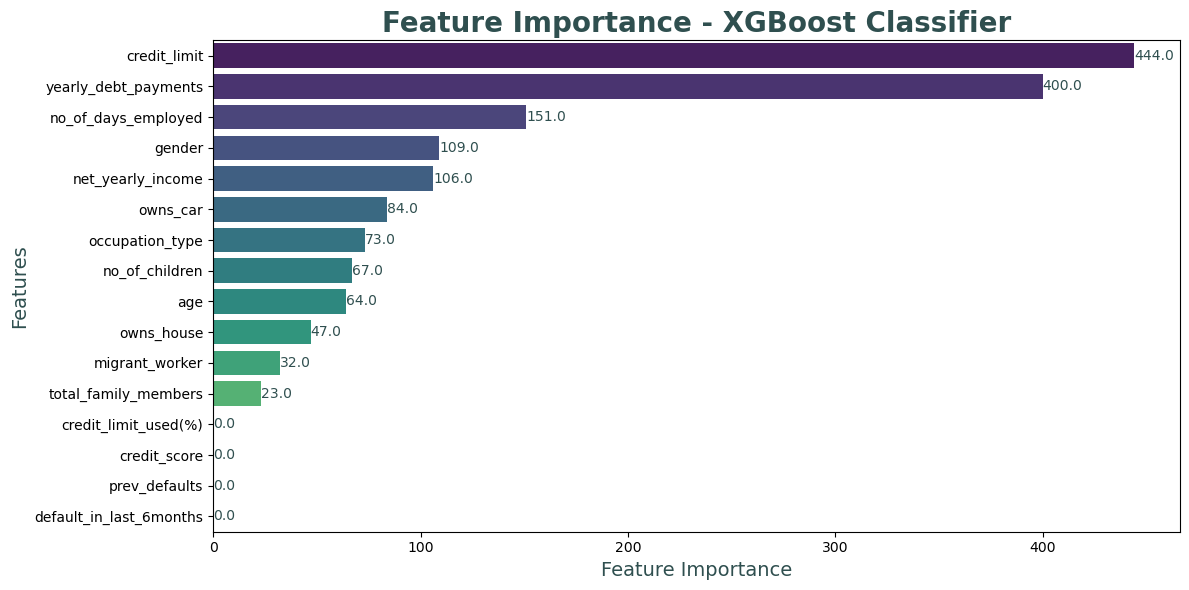

In [22]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='xgb_model_feature_significance', y='Feature', data=xgb_model_feature_significance_sorted, ax=ax, palette='viridis')

for index, value in enumerate(xgb_model_feature_significance_sorted['xgb_model_feature_significance']):
    ax.text(value, index, f'{value:.1f}', va='center', ha='left', fontsize=10, color='#2F4F4F')

ax.set_title("Feature Importance - XGBoost Classifier", fontsize=20, fontweight='bold', color='#2F4F4F')
ax.set_xlabel('Feature Importance', fontsize=14, color='#2F4F4F')
ax.set_ylabel('Features', fontsize=14, color='#2F4F4F')

plt.tight_layout()

xgb_model_feature_significance = plt
xgb_model_feature_significance.show()

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:30px; font-weight: bold;">Prediction and Model Evaluation</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>

In [23]:
xgb_model_y_pred = xgb_model.predict(X_test)
xgb_model_accuracy = accuracy_score(y_test, xgb_model_y_pred)
xgb_model_conf_matrix = confusion_matrix(y_test, xgb_model_y_pred)
xgb_model_class_report = classification_report(y_test, xgb_model_y_pred)

print(f"Accuracy: {xgb_model_accuracy:.4f}")
print("Confusion Matrix:")
print(xgb_model_conf_matrix)
print("Classification Report:")
print(xgb_model_class_report)

Accuracy: 0.9591
Confusion Matrix:
[[7634  329]
 [  27  712]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      7963
           1       0.68      0.96      0.80       739

    accuracy                           0.96      8702
   macro avg       0.84      0.96      0.89      8702
weighted avg       0.97      0.96      0.96      8702



<div style="text-align: center;">
  <span style="color: #FF0000; font-size:40px; font-weight: bold;">02. LightGBM Classifier</span>
  <hr style="border: 2px solid grey; width: 100%;"/>
</div>

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:30px; font-weight: bold;">Model Training and Feature selection</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>

In [24]:
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 25611, number of negative: 32014
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2203
[LightGBM] [Info] Number of data points in the train set: 57625, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444443 -> initscore=-0.223151
[LightGBM] [Info] Start training from score -0.223151


LGBMClassifier(random_state=42)

In [25]:
print(type(lgb_model))  # Should be <class 'lightgbm.sklearn.LGBMClassifier'> or similar


<class 'lightgbm.sklearn.LGBMClassifier'>


In [72]:
lgb_model_feature_importance = lgb_model.feature_importances_  # Correct way to extract feature importance

lgb_model_feature_significance = pd.DataFrame({
    'Feature': X_train.columns,
    'lgb_model_feature_significance': lgb_model_feature_importance
})
lgb_model_feature_significance_sorted = lgb_model_feature_significance.sort_values(by='lgb_model_feature_significance', ascending=False)
lgb_model_feature_significance


,Feature,lgb_model_feature_significance
0,age,200
1,gender,33
2,owns_car,44
3,owns_house,33
4,no_of_children,190
5,net_yearly_income,337
6,no_of_days_employed,395
7,occupation_type,177
8,total_family_members,162
9,migrant_worker,96


C:\Users\ayush\AppData\Local\Temp\ipykernel_15364\3242021935.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='lgb_model_feature_significance', y='Feature', data=lgb_model_feature_significance_sorted, ax=ax, palette='viridis')


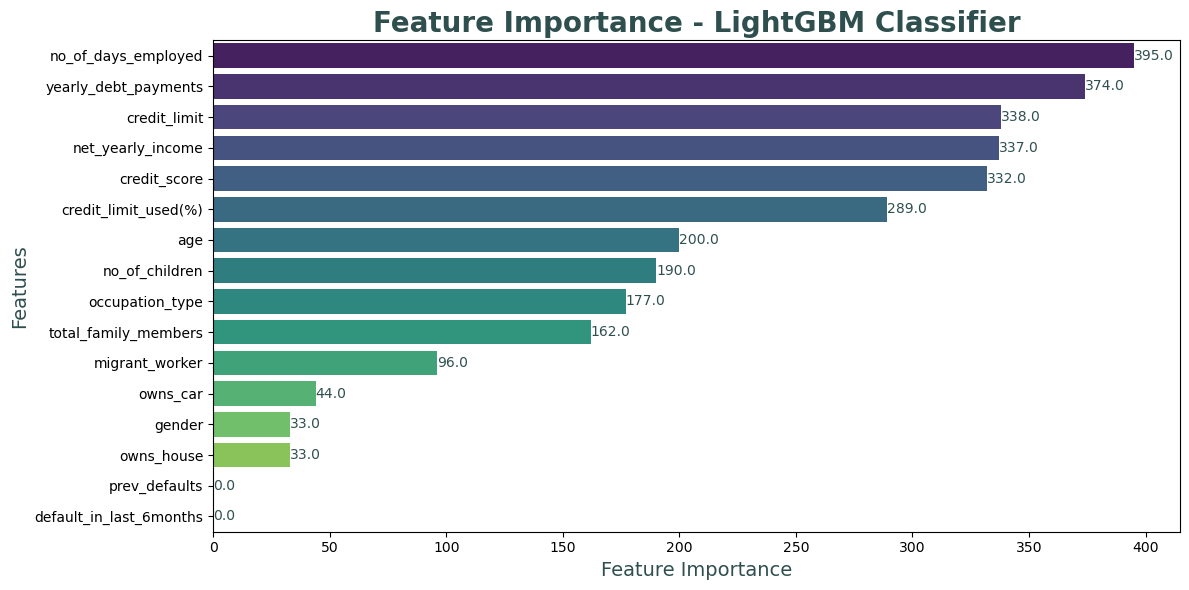

In [27]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='lgb_model_feature_significance', y='Feature', data=lgb_model_feature_significance_sorted, ax=ax, palette='viridis')

for index, value in enumerate(lgb_model_feature_significance_sorted['lgb_model_feature_significance']):
    ax.text(value, index, f'{value:.1f}', va='center', ha='left', fontsize=10, color='#2F4F4F')

ax.set_title("Feature Importance - LightGBM Classifier", fontsize=20, fontweight='bold', color='#2F4F4F')
ax.set_xlabel('Feature Importance', fontsize=14, color='#2F4F4F')
ax.set_ylabel('Features', fontsize=14, color='#2F4F4F')

plt.tight_layout()

lgb_model_feature_significance = plt
lgb_model_feature_significance.show()

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:30px; font-weight: bold;">Prediction and Model Evaluation</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>

In [28]:
lgb_model_y_pred = lgb_model.predict(X_test)

lgb_model_accuracy = accuracy_score(y_test, lgb_model_y_pred)
lgb_model_conf_matrix = confusion_matrix(y_test, lgb_model_y_pred)
lgb_model_class_report = classification_report(y_test, lgb_model_y_pred)

print(f"Accuracy: {lgb_model_accuracy:.4f}")
print("Confusion Matrix:")
print(lgb_model_conf_matrix)
print("Classification Report:")
print(lgb_model_class_report)

Accuracy: 0.9747
Confusion Matrix:
[[7865   98]
 [ 122  617]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      7963
           1       0.86      0.83      0.85       739

    accuracy                           0.97      8702
   macro avg       0.92      0.91      0.92      8702
weighted avg       0.97      0.97      0.97      8702



<div style="text-align: center;">
  <span style="color: #FF0000; font-size:40px; font-weight: bold;">03. CatBoost Classifier</span>
  <hr style="border: 2px solid grey; width: 100%;"/>
</div>

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:30px; font-weight: bold;">Model Training and Feature selection</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>

In [29]:
catboost_model = CatBoostClassifier(iterations=500, depth=5, learning_rate=0.1, random_seed=42, verbose=100)
catboost_model.fit(X_train, y_train)

0:	learn: 0.4526511	total: 170ms	remaining: 1m 24s
100:	learn: 0.0321907	total: 1.03s	remaining: 4.09s
200:	learn: 0.0265179	total: 1.84s	remaining: 2.74s
300:	learn: 0.0226058	total: 2.88s	remaining: 1.91s
400:	learn: 0.0196574	total: 4.29s	remaining: 1.06s
499:	learn: 0.0173257	total: 5.33s	remaining: 0us


In [30]:
catboost_model_feature_importance = catboost_model.get_feature_importance()

# Get the feature names (assuming you have a DataFrame `X_train` with column names)
catboost_model_feature_significance = pd.DataFrame({
    'Feature': X_train.columns,  # Feature names from the training data
    'catboost_model_feature_significance': catboost_model_feature_importance  # Feature importance values
})
catboost_model_feature_significance_sorted = catboost_model_feature_significance.sort_values(by='catboost_model_feature_significance', ascending=False)
catboost_model_feature_significance

,Feature,catboost_model_feature_significance
0,age,1.554111
1,gender,0.126877
2,owns_car,0.787333
3,owns_house,0.452444
4,no_of_children,6.924204
5,net_yearly_income,2.913545
6,no_of_days_employed,3.664087
7,occupation_type,2.406949
8,total_family_members,7.692124
9,migrant_worker,5.700995


C:\Users\ayush\AppData\Local\Temp\ipykernel_15364\3853322135.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='catboost_model_feature_significance', y='Feature', data=catboost_model_feature_significance_sorted, ax=ax, palette='viridis')


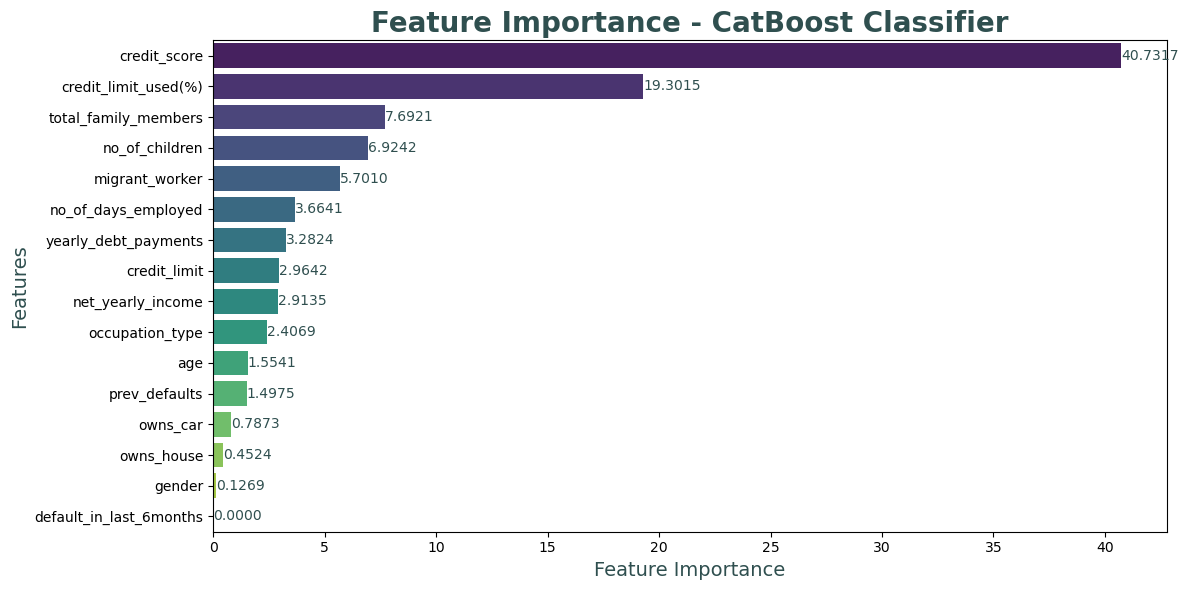

In [31]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='catboost_model_feature_significance', y='Feature', data=catboost_model_feature_significance_sorted, ax=ax, palette='viridis')

for index, value in enumerate(catboost_model_feature_significance_sorted['catboost_model_feature_significance']):
    ax.text(value, index, f'{value:.4f}', va='center', ha='left', fontsize=10, color='#2F4F4F')

ax.set_title("Feature Importance - CatBoost Classifier", fontsize=20, fontweight='bold', color='#2F4F4F')
ax.set_xlabel('Feature Importance', fontsize=14, color='#2F4F4F')
ax.set_ylabel('Features', fontsize=14, color='#2F4F4F')
plt.tight_layout()

catboost_model_feature_significance_plot = plt
catboost_model_feature_significance_plot.show()

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:30px; font-weight: bold;">Prediction and Model Evaluation</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>

In [32]:
catboost_model_y_pred = catboost_model.predict(X_test)

catboost_model_accuracy = accuracy_score(y_test, catboost_model_y_pred)
catboost_model_conf_matrix = confusion_matrix(y_test, catboost_model_y_pred)
catboost_model_class_report = classification_report(y_test, catboost_model_y_pred)

print(f"Accuracy: {catboost_model_accuracy:.4f}")
print("Confusion Matrix:")
print(catboost_model_conf_matrix)
print("Classification Report:")
print(catboost_model_class_report)

Accuracy: 0.9745
Confusion Matrix:
[[7861  102]
 [ 120  619]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      7963
           1       0.86      0.84      0.85       739

    accuracy                           0.97      8702
   macro avg       0.92      0.91      0.92      8702
weighted avg       0.97      0.97      0.97      8702



<div style="text-align: center;">
  <span style="color: #FF0000; font-size:40px; font-weight: bold;">04. Decision Tree Classifier</span>
  <hr style="border: 2px solid grey; width: 100%;"/>
</div>

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:30px; font-weight: bold;">Model Training and Feature selection</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>

In [33]:
dt_model = DecisionTreeClassifier(criterion='gini', max_depth=6, random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, random_state=42)

In [34]:
dt_model_feature_importance = dt_model.feature_importances_

# Get the feature names (assuming you have a DataFrame `X_train` with column names)
dt_model_feature_significance = pd.DataFrame({
    'Feature': X_train.columns,  # Feature names from the training data
    'dt_model_feature_significance': dt_model_feature_importance  # Feature importance values
})
dt_model_feature_significance_sorted = dt_model_feature_significance.sort_values(by='dt_model_feature_significance', ascending=False)
dt_model_feature_significance

,Feature,dt_model_feature_significance
0,age,0.000176
1,gender,0.000000
2,owns_car,0.002859
3,owns_house,0.000000
4,no_of_children,0.000000
5,net_yearly_income,0.000000
6,no_of_days_employed,0.001494
7,occupation_type,0.003410
8,total_family_members,0.004361
9,migrant_worker,0.000000


C:\Users\ayush\AppData\Local\Temp\ipykernel_15364\3859504738.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='dt_model_feature_significance', y='Feature', data=dt_model_feature_significance_sorted, ax=ax, palette='viridis')


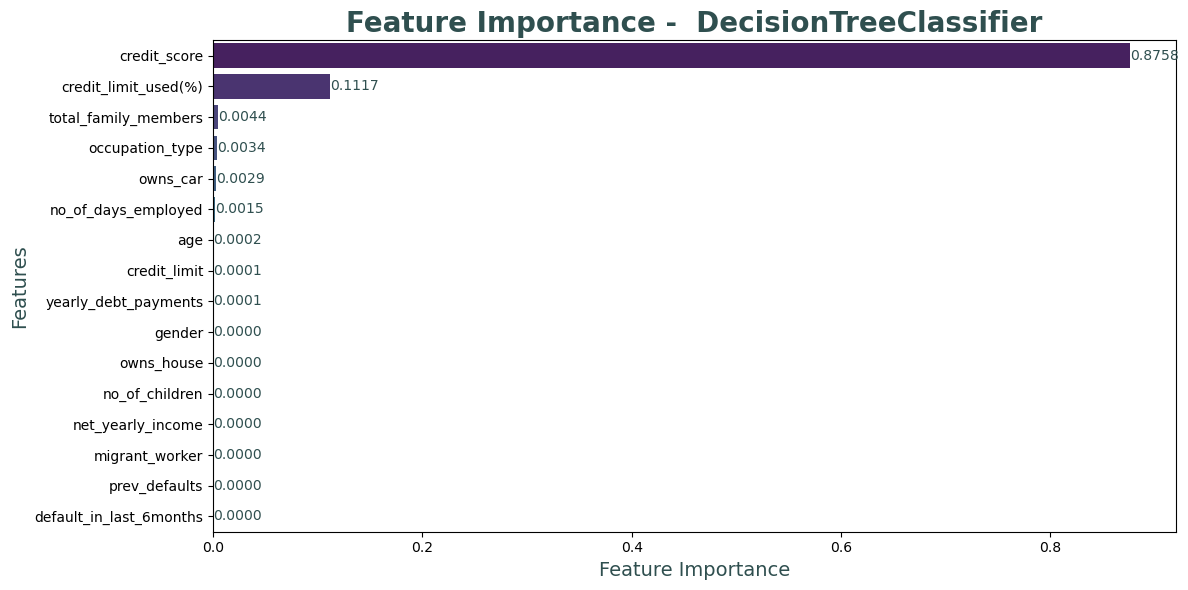

In [35]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='dt_model_feature_significance', y='Feature', data=dt_model_feature_significance_sorted, ax=ax, palette='viridis')

for index, value in enumerate(dt_model_feature_significance_sorted['dt_model_feature_significance']):
    ax.text(value, index, f'{value:.4f}', va='center', ha='left', fontsize=10, color='#2F4F4F')

ax.set_title("Feature Importance -  DecisionTreeClassifier", fontsize=20, fontweight='bold', color='#2F4F4F')
ax.set_xlabel('Feature Importance', fontsize=14, color='#2F4F4F')
ax.set_ylabel('Features', fontsize=14, color='#2F4F4F')
plt.tight_layout()

dt_model_feature_significance_plot = plt
dt_model_feature_significance_plot.show()

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:30px; font-weight: bold;">Prediction and Model Evaluation</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>

In [36]:
dt_model_y_pred = dt_model.predict(X_test)

dt_model_accuracy = accuracy_score(y_test, dt_model_y_pred)
dt_model_conf_matrix = confusion_matrix(y_test, dt_model_y_pred)
dt_model_class_report = classification_report(y_test, dt_model_y_pred)

print(f"Accuracy: {dt_model_accuracy:.4f}")
print("Confusion Matrix:")
print(dt_model_conf_matrix)
print("Classification Report:")
print(dt_model_class_report)

Accuracy: 0.9661
Confusion Matrix:
[[7716  247]
 [  48  691]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      7963
           1       0.74      0.94      0.82       739

    accuracy                           0.97      8702
   macro avg       0.87      0.95      0.90      8702
weighted avg       0.97      0.97      0.97      8702



<div style="text-align: center;">
  <span style="color: #FF0000; font-size:40px; font-weight: bold;">05. Random Forest Classifier</span>
  <hr style="border: 2px solid grey; width: 100%;"/>
</div>

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:30px; font-weight: bold;">Model Training and Feature selection</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>

In [37]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, random_state=42)

In [38]:
rf_model_feature_importance = rf_model.feature_importances_

rf_model_feature_significance = pd.DataFrame({
    'Feature': X_train.columns, 
    'rf_model_feature_significance': rf_model_feature_importance  
})
rf_model_feature_significance_sorted = rf_model_feature_significance.sort_values(by='rf_model_feature_significance', ascending=False)
rf_model_feature_significance

,Feature,rf_model_feature_significance
0,age,0.000823
1,gender,0.000298
2,owns_car,0.014331
3,owns_house,0.003721
4,no_of_children,0.023605
5,net_yearly_income,0.000250
6,no_of_days_employed,0.003147
7,occupation_type,0.004927
8,total_family_members,0.012914
9,migrant_worker,0.019660


C:\Users\ayush\AppData\Local\Temp\ipykernel_15364\2741119784.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='rf_model_feature_significance', y='Feature', data=rf_model_feature_significance_sorted, ax=ax, palette='viridis')


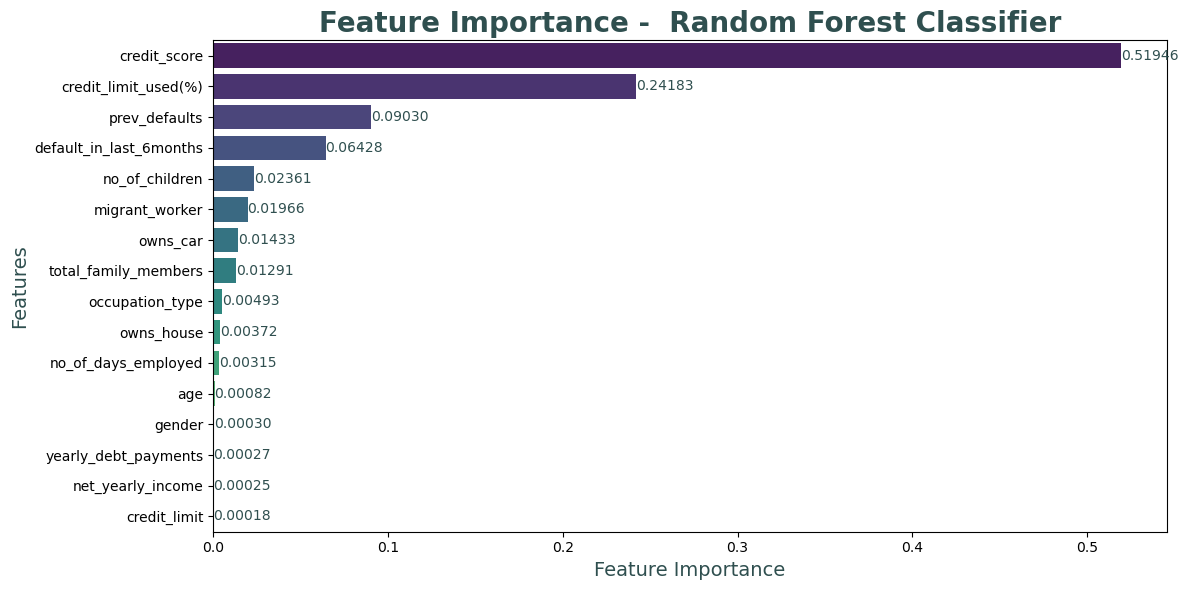

In [39]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='rf_model_feature_significance', y='Feature', data=rf_model_feature_significance_sorted, ax=ax, palette='viridis')

for index, value in enumerate(rf_model_feature_significance_sorted['rf_model_feature_significance']):
    ax.text(value, index, f'{value:.5f}', va='center', ha='left', fontsize=10, color='#2F4F4F')

ax.set_title("Feature Importance -  Random Forest Classifier", fontsize=20, fontweight='bold', color='#2F4F4F')
ax.set_xlabel('Feature Importance', fontsize=14, color='#2F4F4F')
ax.set_ylabel('Features', fontsize=14, color='#2F4F4F')
plt.tight_layout()

rf_model_feature_significance_plot = plt
rf_model_feature_significance_plot.show()

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:30px; font-weight: bold;">Prediction and Model Evaluation</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>

In [40]:
rf_model_y_pred = rf_model.predict(X_test)

rf_model_accuracy = accuracy_score(y_test, rf_model_y_pred)
rf_model_conf_matrix = confusion_matrix(y_test, rf_model_y_pred)
rf_model_class_report = classification_report(y_test, rf_model_y_pred)

print(f"Accuracy: {rf_model_accuracy:.4f}")
print("Confusion Matrix:")
print(rf_model_conf_matrix)
print("Classification Report:")
print(rf_model_class_report)

Accuracy: 0.9683
Confusion Matrix:
[[7748  215]
 [  61  678]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      7963
           1       0.76      0.92      0.83       739

    accuracy                           0.97      8702
   macro avg       0.88      0.95      0.91      8702
weighted avg       0.97      0.97      0.97      8702



<div style="text-align: center;">
  <span style="color: #FF0000; font-size:40px; font-weight: bold;">06. K-Neighbours Classifier</span>
  <hr style="border: 2px solid grey; width: 100%;"/>
</div>

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:30px; font-weight: bold;">Model Training and Feature selection</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>

In [41]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [42]:
knn_model_feature_importance = permutation_importance(knn_model, X_train_scaled, y_train, n_repeats=10, random_state=42)
#(Above will take around 12
#  min and full CPU, be careful)
knn_model_feature_significance = pd.DataFrame({
    'Feature': X_train.columns, 
    'knn_model_feature_significance': knn_model_feature_importance.importances_mean 
})
knn_model_feature_significance_sorted = knn_model_feature_significance.sort_values(by='knn_model_feature_significance', ascending=False)
knn_model_feature_significance

,Feature,knn_model_feature_significance
0,age,0.015443
1,gender,0.011346
2,owns_car,0.017086
3,owns_house,0.013258
4,no_of_children,0.012536
5,net_yearly_income,0.000153
6,no_of_days_employed,0.008826
7,occupation_type,0.015885
8,total_family_members,0.014681
9,migrant_worker,0.011538


C:\Users\ayush\AppData\Local\Temp\ipykernel_15364\168890697.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='knn_model_feature_significance', y='Feature', data=knn_model_feature_significance_sorted, ax=ax, palette='viridis')


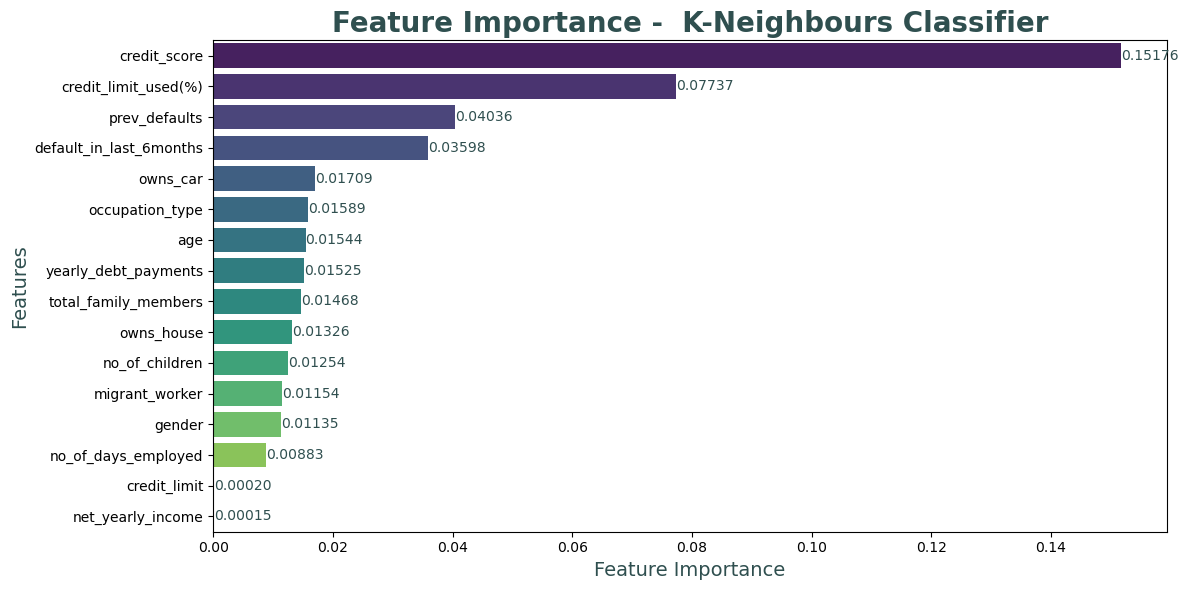

In [43]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='knn_model_feature_significance', y='Feature', data=knn_model_feature_significance_sorted, ax=ax, palette='viridis')

for index, value in enumerate(knn_model_feature_significance_sorted['knn_model_feature_significance']):
    ax.text(value, index, f'{value:.5f}', va='center', ha='left', fontsize=10, color='#2F4F4F')

ax.set_title("Feature Importance -  K-Neighbours Classifier", fontsize=20, fontweight='bold', color='#2F4F4F')
ax.set_xlabel('Feature Importance', fontsize=14, color='#2F4F4F')
ax.set_ylabel('Features', fontsize=14, color='#2F4F4F')
plt.tight_layout()

knn_model_feature_significance_plot = plt
knn_model_feature_significance_plot.show()

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:30px; font-weight: bold;">Prediction and Model Evaluation</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>

In [44]:
knn_model_y_pred = knn_model.predict(X_test_scaled)

knn_model_accuracy = accuracy_score(y_test, knn_model_y_pred)
knn_model_conf_matrix = confusion_matrix(y_test, knn_model_y_pred)
knn_model_class_report = classification_report(y_test, knn_model_y_pred)

print(f"Accuracy: {knn_model_accuracy:.4f}")
print("Confusion Matrix:")
print(knn_model_conf_matrix)
print("Classification Report:")
print(knn_model_class_report)

Accuracy: 0.9515
Confusion Matrix:
[[7637  326]
 [  96  643]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      7963
           1       0.66      0.87      0.75       739

    accuracy                           0.95      8702
   macro avg       0.83      0.91      0.86      8702
weighted avg       0.96      0.95      0.95      8702



<div style="text-align: center;">
  <span style="color: #FF0000; font-size:40px; font-weight: bold;">07. Support Vector Machine</span>
  <hr style="border: 2px solid grey; width: 100%;"/>
</div>

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:30px; font-weight: bold;">Model Training and Feature selection</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>

In [45]:
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_scaled, y_train)

SVC(kernel='linear', random_state=42)

In [46]:
svm_model_coef = svm_model.coef_.flatten()  # Flatten to make it 1D if it's multi-class

# Create a DataFrame to hold the feature importance (absolute values of the coefficients)
svm_model_feature_significance = pd.DataFrame({
    'Feature': X_train.columns, 
    # 'svm_model_feature_significance': np.abs(svm_model_coef)  # Use absolute value of coefficients
    'svm_model_feature_significance': svm_model_coef
})
svm_model_feature_significance_sorted = svm_model_feature_significance.sort_values(by='svm_model_feature_significance', ascending=False)
svm_model_feature_significance

,Feature,svm_model_feature_significance
0,age,-0.013562
1,gender,-0.107198
2,owns_car,-0.301932
3,owns_house,-0.279127
4,no_of_children,0.017649
5,net_yearly_income,0.533088
6,no_of_days_employed,-0.120548
7,occupation_type,-0.103202
8,total_family_members,-0.006150
9,migrant_worker,0.084099


C:\Users\ayush\AppData\Local\Temp\ipykernel_15364\3476562288.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='svm_model_feature_significance', y='Feature', data=svm_model_feature_significance_sorted, ax=ax, palette='viridis')


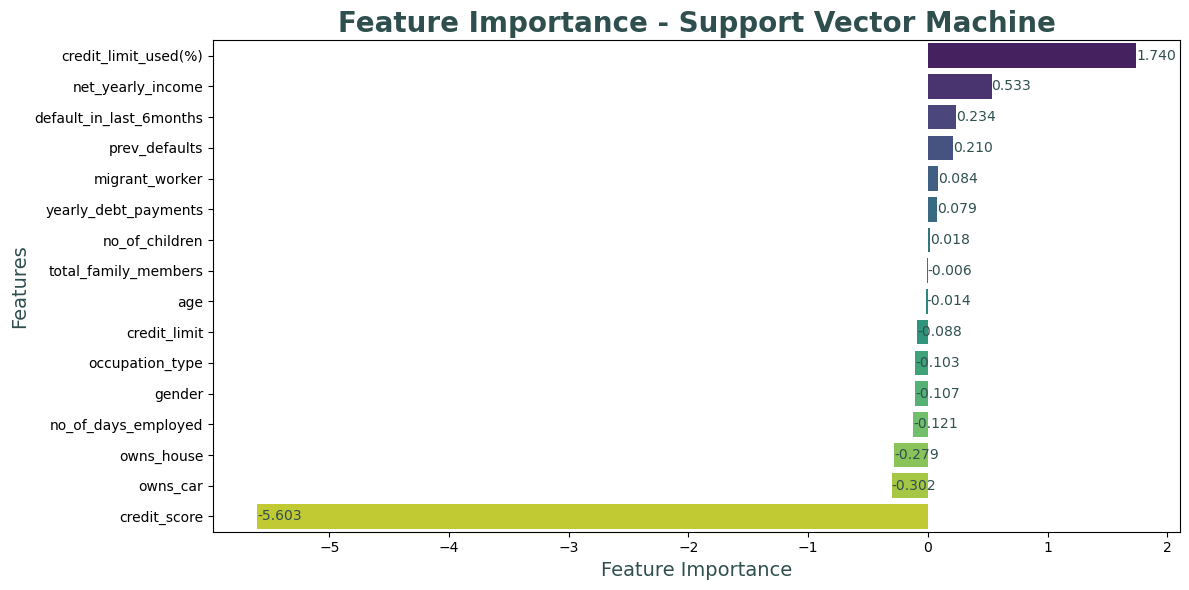

In [47]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='svm_model_feature_significance', y='Feature', data=svm_model_feature_significance_sorted, ax=ax, palette='viridis')

for index, value in enumerate(svm_model_feature_significance_sorted['svm_model_feature_significance']):
    ax.text(value, index, f'{value:.3f}', va='center', ha='left', fontsize=10, color='#2F4F4F')

ax.set_title("Feature Importance - Support Vector Machine", fontsize=20, fontweight='bold', color='#2F4F4F')
ax.set_xlabel('Feature Importance', fontsize=14, color='#2F4F4F')
ax.set_ylabel('Features', fontsize=14, color='#2F4F4F')
plt.tight_layout()

svm_model_feature_significance_plot = plt
svm_model_feature_significance_plot.show()

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:30px; font-weight: bold;">Prediction and Model Evaluation</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>

In [48]:
svm_model_y_pred = svm_model.predict(X_test_scaled)

svm_model_accuracy = accuracy_score(y_test, svm_model_y_pred)
svm_model_conf_matrix = confusion_matrix(y_test, svm_model_y_pred)
svm_model_class_report = classification_report(y_test, svm_model_y_pred)

print(f"Accuracy: {svm_model_accuracy:.4f}")
print("Confusion Matrix:")
print(svm_model_conf_matrix)
print("Classification Report:")
print(svm_model_class_report)

Accuracy: 0.9613
Confusion Matrix:
[[7678  285]
 [  52  687]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      7963
           1       0.71      0.93      0.80       739

    accuracy                           0.96      8702
   macro avg       0.85      0.95      0.89      8702
weighted avg       0.97      0.96      0.96      8702



<div style="text-align: center;">
  <span style="color: #FF0000; font-size:40px; font-weight: bold;">08. Adaptive Boosting Classifier</span>
  <hr style="border: 2px solid grey; width: 100%;"/>
</div>

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:30px; font-weight: bold;">Model Training and Feature selection</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>

In [49]:
ada_model = AdaBoostClassifier(n_estimators=100, learning_rate = 0.01, random_state=22)
ada_model.fit(X_train, y_train)

c:\Users\ayush\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(learning_rate=0.01, n_estimators=100, random_state=22)

In [50]:
ada_model_feature_importance = ada_model.feature_importances_

ada_model_feature_significance = pd.DataFrame({
    'Feature': X_train.columns, 
    'ada_model_feature_significance': ada_model_feature_importance  
})
ada_model_feature_significance_sorted = ada_model_feature_significance.sort_values(by='ada_model_feature_significance', ascending=False)
ada_model_feature_significance

,Feature,ada_model_feature_significance
0,age,0.00
1,gender,0.00
2,owns_car,0.01
3,owns_house,0.00
4,no_of_children,0.05
5,net_yearly_income,0.00
6,no_of_days_employed,0.00
7,occupation_type,0.05
8,total_family_members,0.01
9,migrant_worker,0.01


C:\Users\ayush\AppData\Local\Temp\ipykernel_15364\1220884924.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='ada_model_feature_significance', y='Feature', data=ada_model_feature_significance_sorted, ax=ax, palette='viridis')


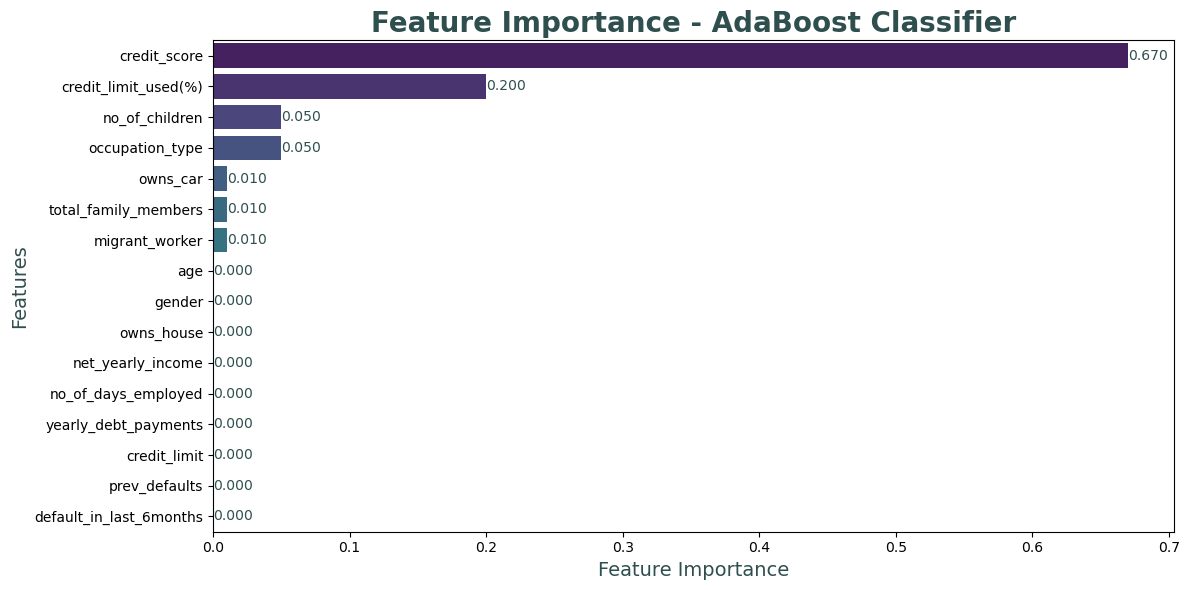

In [51]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='ada_model_feature_significance', y='Feature', data=ada_model_feature_significance_sorted, ax=ax, palette='viridis')

for index, value in enumerate(ada_model_feature_significance_sorted['ada_model_feature_significance']):
    ax.text(value, index, f'{value:.3f}', va='center', ha='left', fontsize=10, color='#2F4F4F')

ax.set_title("Feature Importance - AdaBoost Classifier", fontsize=20, fontweight='bold', color='#2F4F4F')
ax.set_xlabel('Feature Importance', fontsize=14, color='#2F4F4F')
ax.set_ylabel('Features', fontsize=14, color='#2F4F4F')
plt.tight_layout()

ada_model_feature_significance_plot = plt
ada_model_feature_significance_plot.show()

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:30px; font-weight: bold;">Prediction and Model Evaluation</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div
>

In [52]:
ada_model_y_pred = ada_model.predict(X_test)

ada_model_accuracy = accuracy_score(y_test, ada_model_y_pred)
ada_model_conf_matrix = confusion_matrix(y_test, ada_model_y_pred)
ada_model_class_report = classification_report(y_test, ada_model_y_pred)

print(f"Accuracy: {ada_model_accuracy:.4f}")
print("Confusion Matrix:")
print(ada_model_conf_matrix)
print("Classification Report:")
print(ada_model_class_report)

Accuracy: 0.9577
Confusion Matrix:
[[7613  350]
 [  18  721]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      7963
           1       0.67      0.98      0.80       739

    accuracy                           0.96      8702
   macro avg       0.84      0.97      0.89      8702
weighted avg       0.97      0.96      0.96      8702



<div style="text-align: center;">
  <span style="color: #FF0000; font-size:40px; font-weight: bold;">09. Logistic Regression</span>
  <hr style="border: 2px solid grey; width: 100%;"/>
</div>

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:30px; font-weight: bold;">Model Training and Feature selection</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>

In [53]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train_scaled, y_train)

LogisticRegression()

In [54]:
logistic_model_coefficients = logistic_model.coef_[0]

logistic_model_feature_significance = pd.DataFrame({
    'Feature': X_train.columns, 
    'logistic_model_feature_significance': logistic_model_coefficients 
})
logistic_model_feature_significance_sorted = logistic_model_feature_significance.sort_values(by='logistic_model_feature_significance', ascending=False)
logistic_model_feature_significance

,Feature,logistic_model_feature_significance
0,age,-0.006591
1,gender,-0.132391
2,owns_car,-0.420188
3,owns_house,-0.400151
4,no_of_children,0.022741
5,net_yearly_income,0.175225
6,no_of_days_employed,-0.202370
7,occupation_type,-0.120310
8,total_family_members,-0.000096
9,migrant_worker,0.110911


C:\Users\ayush\AppData\Local\Temp\ipykernel_15364\895998697.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='logistic_model_feature_significance', y='Feature', data=logistic_model_feature_significance_sorted, ax=ax, palette='viridis')


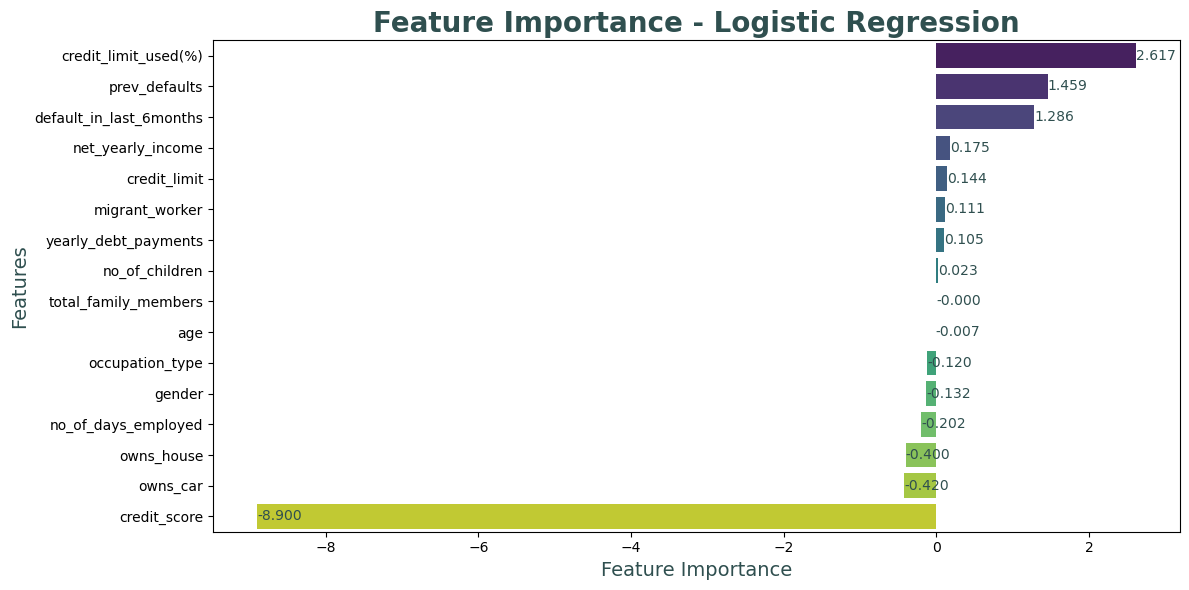

In [55]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='logistic_model_feature_significance', y='Feature', data=logistic_model_feature_significance_sorted, ax=ax, palette='viridis')

for index, value in enumerate(logistic_model_feature_significance_sorted['logistic_model_feature_significance']):
    ax.text(value, index, f'{value:.3f}', va='center', ha='left', fontsize=10, color='#2F4F4F')

ax.set_title("Feature Importance - Logistic Regression", fontsize=20, fontweight='bold', color='#2F4F4F')
ax.set_xlabel('Feature Importance', fontsize=14, color='#2F4F4F')
ax.set_ylabel('Features', fontsize=14, color='#2F4F4F')
plt.tight_layout()

logistic_model_feature_significance_plot = plt
logistic_model_feature_significance_plot.show()

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:30px; font-weight: bold;">Prediction and Model Evaluation</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>

In [56]:
# Predictions
logistic_model_y_pred = logistic_model.predict(X_test_scaled)

# Model Evaluation
logistic_model_accuracy = accuracy_score(y_test, logistic_model_y_pred)
print(f"Accuracy: {logistic_model_accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, logistic_model_y_pred))

Accuracy: 0.9635
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      7963
           1       0.72      0.93      0.81       739

    accuracy                           0.96      8702
   macro avg       0.86      0.95      0.90      8702
weighted avg       0.97      0.96      0.97      8702



<div style="text-align: center;">
  <span style="color: #FF0000; font-size:40px; font-weight: bold;">10. Gradient Boosting Classifier</span>
  <hr style="border: 2px solid grey; width: 100%;"/>
</div>

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:30px; font-weight: bold;">Model Training and Feature selection</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>

In [57]:
gbm_model = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_depth=5, random_state=42)
gbm_model.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=5, n_estimators=500, random_state=42)

In [58]:
gbm_model_feature_importance = gbm_model.feature_importances_

gbm_model_feature_significance = pd.DataFrame({
    'Feature': X_train.columns, 
    'gbm_model_feature_significance': gbm_model_feature_importance  
})
gbm_model_feature_significance_sorted = gbm_model_feature_significance.sort_values(by='gbm_model_feature_significance', ascending=False)
gbm_model_feature_significance

,Feature,gbm_model_feature_significance
0,age,0.000746
1,gender,0.000126
2,owns_car,0.001771
3,owns_house,0.001509
4,no_of_children,0.006528
5,net_yearly_income,0.001646
6,no_of_days_employed,0.002607
7,occupation_type,0.002659
8,total_family_members,0.008126
9,migrant_worker,0.005026


C:\Users\ayush\AppData\Local\Temp\ipykernel_15364\954021199.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='gbm_model_feature_significance', y='Feature', data=gbm_model_feature_significance_sorted, ax=ax, palette='viridis')


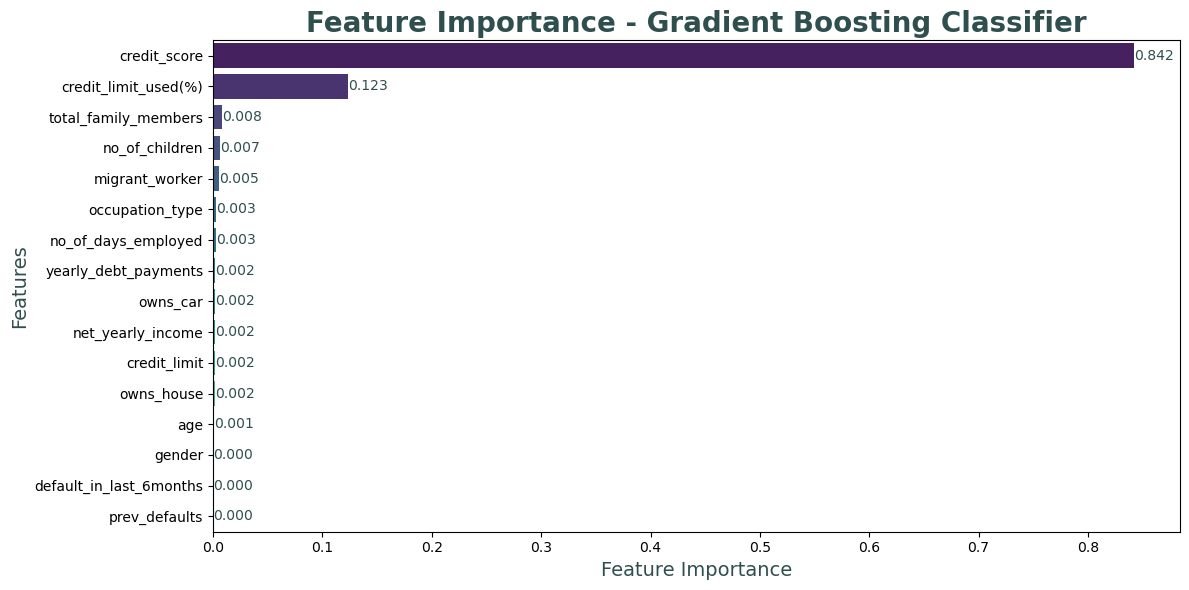

In [59]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='gbm_model_feature_significance', y='Feature', data=gbm_model_feature_significance_sorted, ax=ax, palette='viridis')

for index, value in enumerate(gbm_model_feature_significance_sorted['gbm_model_feature_significance']):
    ax.text(value, index, f'{value:.3f}', va='center', ha='left', fontsize=10, color='#2F4F4F')

ax.set_title("Feature Importance - Gradient Boosting Classifier", fontsize=20, fontweight='bold', color='#2F4F4F')
ax.set_xlabel('Feature Importance', fontsize=14, color='#2F4F4F')
ax.set_ylabel('Features', fontsize=14, color='#2F4F4F')
plt.tight_layout()

gbm_model_feature_significance_plot = plt
gbm_model_feature_significance_plot.show()

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:30px; font-weight: bold;">Prediction and Model Evaluation</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>

In [60]:
# Predictions
gbm_model_y_pred = gbm_model.predict(X_test)

# Model Evaluation
gbm_model_accuracy = accuracy_score(y_test, gbm_model_y_pred)
print(f"Accuracy: {gbm_model_accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, gbm_model_y_pred))

Accuracy: 0.9744
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      7963
           1       0.87      0.82      0.84       739

    accuracy                           0.97      8702
   macro avg       0.93      0.90      0.92      8702
weighted avg       0.97      0.97      0.97      8702



<div style="text-align: center;">
  <span style="color: #FF0000; font-size:40px; font-weight: bold;">11. Neural Networks (MLP Classifier)</span>
  <hr style="border: 2px solid grey; width: 100%;"/>
</div>

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:30px; font-weight: bold;">Model Training and Feature selection</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>

In [61]:
mlp_model = MLPClassifier(hidden_layer_sizes=(100,50), activation='relu', max_iter=500, random_state=42)
mlp_model.fit(X_train_scaled, y_train)

MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)

In [62]:
mlp_model_feature_importance = permutation_importance(mlp_model, X_train_scaled, y_train, n_repeats=10, random_state=42)

mlp_model_feature_significance = pd.DataFrame({
    'Feature': X_train.columns, 
    'mlp_model_feature_significance': mlp_model_feature_importance.importances_mean
})
mlp_model_feature_significance_sorted = mlp_model_feature_significance.sort_values(by='mlp_model_feature_significance', ascending=False)
mlp_model_feature_significance

,Feature,mlp_model_feature_significance
0,age,0.014608
1,gender,0.008715
2,owns_car,0.009399
3,owns_house,0.010360
4,no_of_children,0.055132
5,net_yearly_income,0.004889
6,no_of_days_employed,0.018249
7,occupation_type,0.022740
8,total_family_members,0.055459
9,migrant_worker,0.014636


C:\Users\ayush\AppData\Local\Temp\ipykernel_15364\1129891281.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='mlp_model_feature_significance', y='Feature', data=mlp_model_feature_significance_sorted, ax=ax, palette='viridis')


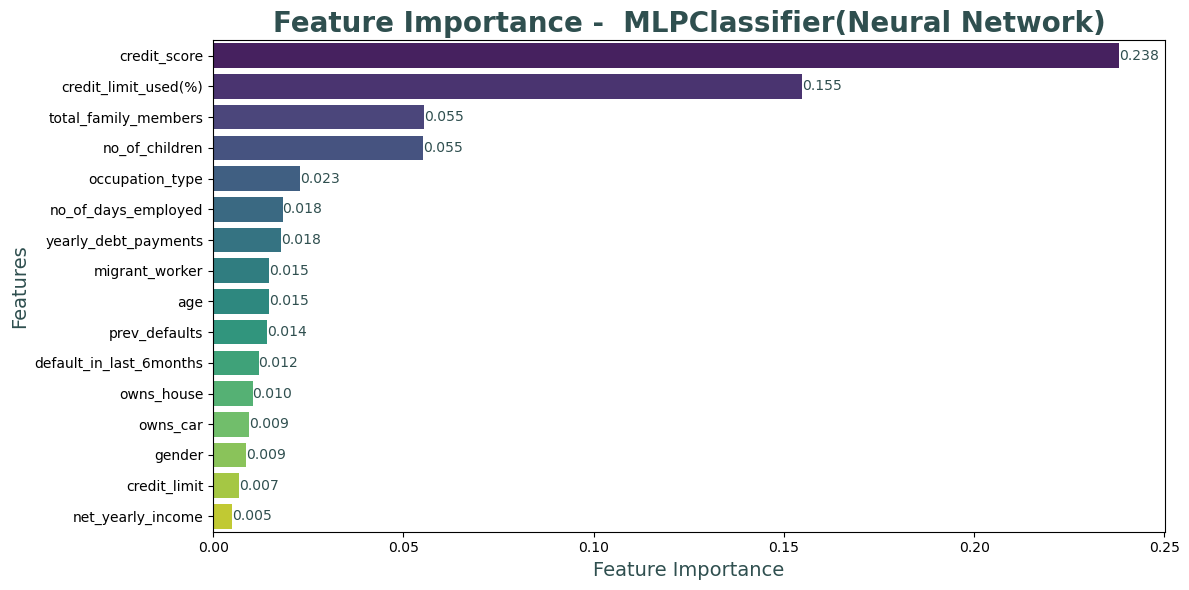

In [63]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='mlp_model_feature_significance', y='Feature', data=mlp_model_feature_significance_sorted, ax=ax, palette='viridis')

for index, value in enumerate(mlp_model_feature_significance_sorted['mlp_model_feature_significance']):
    ax.text(value, index, f'{value:.3f}', va='center', ha='left', fontsize=10, color='#2F4F4F')

ax.set_title("Feature Importance -  MLPClassifier(Neural Network)", fontsize=20, fontweight='bold', color='#2F4F4F')
ax.set_xlabel('Feature Importance', fontsize=14, color='#2F4F4F')
ax.set_ylabel('Features', fontsize=14, color='#2F4F4F')
plt.tight_layout()

mlp_model_feature_significance_plot = plt
mlp_model_feature_significance_plot.show()

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:30px; font-weight: bold;">Prediction and Model Evaluation</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>

In [64]:
# Predictions
mlp_model_y_pred = mlp_model.predict(X_test_scaled)

# Model Evaluation
mlp_model_accuracy = accuracy_score(y_test, mlp_model_y_pred)
print(f"Accuracy: {mlp_model_accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, mlp_model_y_pred))

Accuracy: 0.9712
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      7963
           1       0.81      0.86      0.83       739

    accuracy                           0.97      8702
   macro avg       0.90      0.92      0.91      8702
weighted avg       0.97      0.97      0.97      8702



<div style="text-align: center;">
  <span style="color: #FF0000; font-size:40px; font-weight: bold;">12. Extra Trees Classifier</span>
  <hr style="border: 2px solid grey; width: 100%;"/>
</div>

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:30px; font-weight: bold;">Model Training and Feature selection</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>

In [65]:
et_model = ExtraTreesClassifier(n_estimators=500, max_depth=10, random_state=42)
et_model.fit(X_train, y_train)

ExtraTreesClassifier(max_depth=10, n_estimators=500, random_state=42)

In [66]:
et_model_feature_importance = et_model.feature_importances_

et_model_feature_significance = pd.DataFrame({
    'Feature': X_train.columns, 
    'et_model_feature_significance': et_model_feature_importance  
})
et_model_feature_significance_sorted = et_model_feature_significance.sort_values(by='et_model_feature_significance', ascending=False)
et_model_feature_significance

,Feature,et_model_feature_significance
0,age,0.002063
1,gender,0.002895
2,owns_car,0.030892
3,owns_house,0.018403
4,no_of_children,0.004258
5,net_yearly_income,0.000328
6,no_of_days_employed,0.004814
7,occupation_type,0.006813
8,total_family_members,0.004124
9,migrant_worker,0.019950


C:\Users\ayush\AppData\Local\Temp\ipykernel_15364\2607057498.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='et_model_feature_significance', y='Feature', data=et_model_feature_significance_sorted, ax=ax, palette='viridis')


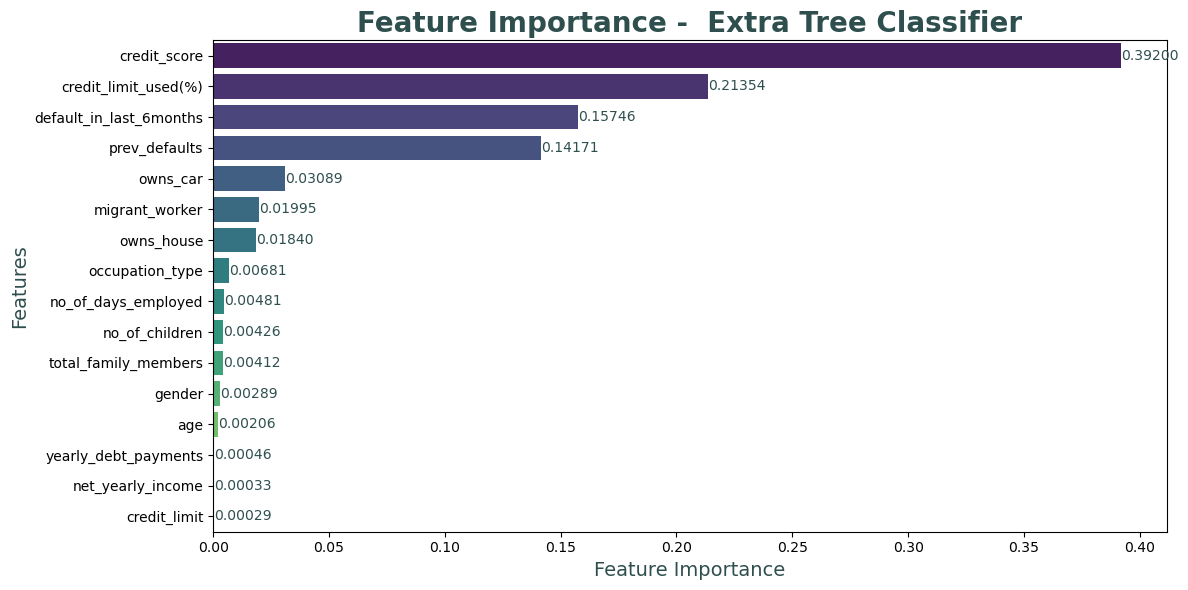

In [67]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='et_model_feature_significance', y='Feature', data=et_model_feature_significance_sorted, ax=ax, palette='viridis')

for index, value in enumerate(et_model_feature_significance_sorted['et_model_feature_significance']):
    ax.text(value, index, f'{value:.5f}', va='center', ha='left', fontsize=10, color='#2F4F4F')

ax.set_title("Feature Importance -  Extra Tree Classifier", fontsize=20, fontweight='bold', color='#2F4F4F')
ax.set_xlabel('Feature Importance', fontsize=14, color='#2F4F4F')
ax.set_ylabel('Features', fontsize=14, color='#2F4F4F')
plt.tight_layout()

et_model_feature_significance_plot = plt
et_model_feature_significance_plot.show()

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:30px; font-weight: bold;">Prediction and Model Evaluation</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>

In [68]:
# Predictions
et_model_y_pred = et_model.predict(X_test)

# Model Evaluation
et_model_accuracy = accuracy_score(y_test, et_model_y_pred)
print(f"Accuracy: {et_model_accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, et_model_y_pred))

Accuracy: 0.9708
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      7963
           1       0.80      0.88      0.84       739

    accuracy                           0.97      8702
   macro avg       0.89      0.93      0.91      8702
weighted avg       0.97      0.97      0.97      8702



<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:45px; font-weight: bold;">Feature Significance of Models</span>
  <hr style="border: 2px solid grey; width: 100%;"/>
</div>

In [69]:
models = {'Extra Tree Classifier':et_model, 
              'MLP Classifier (Neural Networks)':mlp_model, 
              'Gradient Boosting Classifier':gbm_model,
              'Logistic Regression':logistic_model,
              'Adaptive Boosting Classifier':ada_model, 
              'Support Vector Machine':svm_model, 
              'K-Neighbours Classifier':knn_model, 
              'Random Forest Classifier':rf_model, 
              'Decision Tree Classifier':dt_model,
              'CatBoost Classifier':catboost_model,
              'LightGBM Classifier':lgb_model, 
              'XGBoost Classifier':xgb_model}

In [73]:
Feature_significance = et_model_feature_significance.merge(mlp_model_feature_significance, on='Feature', how='outer') \
                                           .merge(gbm_model_feature_significance, on='Feature', how='outer') \
                                           .merge(logistic_model_feature_significance, on='Feature', how='outer') \
                                           .merge(ada_model_feature_significance, on='Feature', how='outer') \
                                           .merge(svm_model_feature_significance, on='Feature', how='outer') \
                                           .merge(knn_model_feature_significance, on='Feature', how='outer') \
                                           .merge(rf_model_feature_significance, on='Feature', how='outer') \
                                           .merge(dt_model_feature_significance, on='Feature', how='outer') \
                                           .merge(catboost_model_feature_significance, on='Feature', how='outer') \
                                           .merge(lgb_model_feature_significance, on='Feature', how='outer') \
                                           .merge(xgb_model_feature_significance, on='Feature', how='outer')
Feature_significance.columns = ['Features', 'Extra Tree Classifier', 'MLP Classifier (Neural Networks)', 'Gradient Boosting Classifier', 'Logistic Regression', 
     'Adaptive Boosting Classifier', 'Support Vector Machine', 'K-Neighbours Classifier', 'Random Forest Classifier', 'Decision Tree Classifier', 
    'CatBoost Classifier', 'LightGBM Classifier', 'XGBoost Classifier']

Feature_significance


,Features,Extra Tree Classifier,MLP Classifier (Neural Networks),Gradient Boosting Classifier,Logistic Regression,Adaptive Boosting Classifier,Support Vector Machine,K-Neighbours Classifier,Random Forest Classifier,Decision Tree Classifier,CatBoost Classifier,LightGBM Classifier,XGBoost Classifier
0,age,0.002063,0.014608,0.000746,-0.006591,0.00,-0.013562,0.015443,0.000823,0.000176,1.554111,200,64.0
1,credit_limit,0.000294,0.006775,0.001591,0.144292,0.00,-0.088363,0.000200,0.000180,0.000125,2.964194,338,444.0
2,credit_limit_used(%),0.213540,0.154759,0.123430,2.616808,0.20,1.739693,0.077374,0.241826,0.111729,19.301530,289,0.0
3,credit_score,0.392000,0.238133,0.842108,-8.900225,0.67,-5.603178,0.151759,0.519464,0.875786,40.731688,332,0.0
4,default_in_last_6months,0.157457,0.011946,0.000005,1.285765,0.00,0.233652,0.035984,0.064283,0.000000,0.000000,0,0.0
5,gender,0.002895,0.008715,0.000126,-0.132391,0.00,-0.107198,0.011346,0.000298,0.000000,0.126877,33,109.0
6,migrant_worker,0.019950,0.014636,0.005026,0.110911,0.01,0.084099,0.011538,0.019660,0.000000,5.700995,96,32.0
7,net_yearly_income,0.000328,0.004889,0.001646,0.175225,0.00,0.533088,0.000153,0.000250,0.000000,2.913545,337,106.0
8,no_of_children,0.004258,0.055132,0.006528,0.022741,0.05,0.017649,0.012536,0.023605,0.000000,6.924204,190,67.0
9,no_of_days_employed,0.004814,0.018249,0.002607,-0.202370,0.00,-0.120548,0.008826,0.003147,0.001494,3.664087,395,151.0


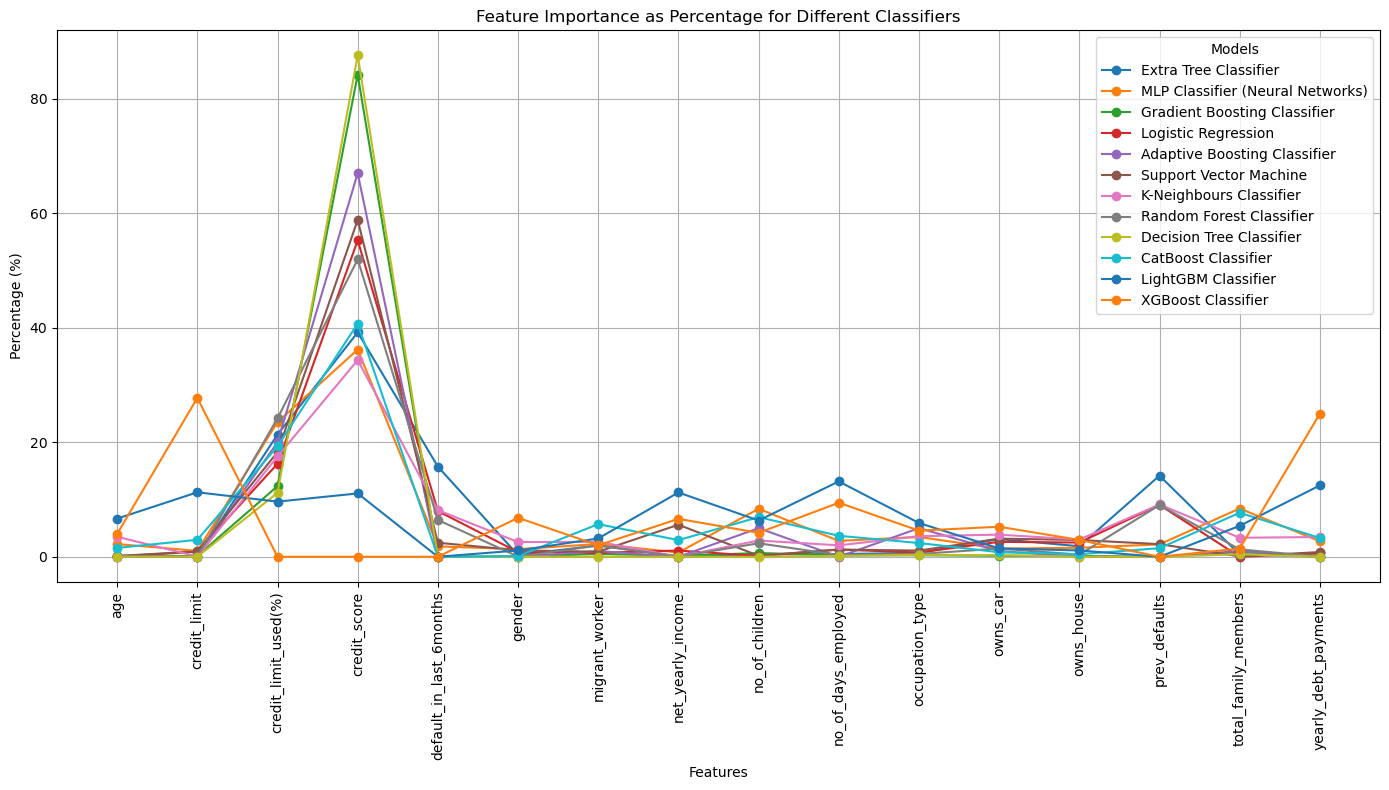

In [78]:
plt.figure(figsize=(14, 8))

for model in models:
    # Compute the sum of absolute values of feature importance for percentage
    sum_abs_value = sum(np.abs(Feature_significance[model]))
    percentage_data = (np.abs(np.array(Feature_significance[model])) / sum_abs_value) * 100
    plt.plot(Feature_significance["Features"], percentage_data, marker='o', label=model)

plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Percentage (%)')
plt.title('Feature Importance as Percentage for Different Classifiers')
plt.grid(True)
plt.tight_layout()
plt.legend(title="Models", loc='upper right', frameon=True)
plt.show()



<div style="text-align: center;">
  <span style="color: #FF0000; font-size:40px; font-weight: bold;">13*. Mode Classifier</span>
  <hr style="border: 2px solid grey; width: 100%;"/>
</div>

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:30px; font-weight: bold;">Prediction and Model Evaluation</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>

In [79]:
result = pd.DataFrame()
for model_name, model in models.items():
    if model_name in ['K-Neighbours Classifier', 'Support Vector Machine', 'Logistic Regression', 'MLP Classifier (Neural Networks)']:
        predictions = model.predict(X_test_scaled)
    else:
        predictions = model.predict(X_test)
    result[model_name] = predictions

result["Majority Prediction"] = result.mode(axis=1)[0]
result["Majority Prediction"] = result["Majority Prediction"].astype(int)

mix_model_y_pred = result["Majority Prediction"]

In [80]:
mix_model_accuracy = accuracy_score(y_test, mix_model_y_pred)
print(f"Accuracy: {mix_model_accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, mix_model_y_pred))

Accuracy: 0.9707
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      7963
           1       0.79      0.89      0.84       739

    accuracy                           0.97      8702
   macro avg       0.89      0.93      0.91      8702
weighted avg       0.97      0.97      0.97      8702



In [81]:
# Sample 20 data points from the dataset
sample_data = df_filtered.sample(n=20)

# Initialize result DataFrame
result_df = pd.DataFrame()
result_df['customer_id'] = sample_data['customer_id']
result_df['Actual Default'] = sample_data['credit_card_default']

# Prepare features and apply scaling where necessary
feature_columns = [col for col in df_filtered.columns if col not in ['credit_card_default', 'customer_id', 'name']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(sample_data[feature_columns])

# Store predictions for each model
for model_name, model in models.items():
    if model_name in ['K-Neighbours Classifier', 'Support Vector Machine', 'Logistic Regression', 'MLP Classifier (Neural Networks)']:
        predictions = model.predict(scaled_features)
    else:
        predictions = model.predict(sample_data[feature_columns])
    
    result_df[model_name] = predictions

# Add a column for the "Mixed Classifier" based on majority voting
result_df['Majority Classifier'] = result_df[[model_name for model_name in models]].apply(lambda x: 1 if x.sum() > len(x) / 2 else 0, axis=1)

# Reorder columns to place "Mixed Classifier" next to "Actual Default"
cols = ['customer_id', 'Actual Default', 'Majority Classifier'] + [model_name for model_name in models]
result_df = result_df[cols]

# Function to highlight correctness
def highlight_correctness(val, actual):
    """
    Color cells light blue if prediction matches actual default, light red otherwise.
    """
    if val == actual:
        return 'background-color: #ADD8E6; color: black; font-weight: bold; border: 1px solid black'  # Light Blue for Correct
    else:
        return 'background-color: #FFA07A; color: black; font-weight: bold; border: 1px solid black'  # Light Red for Incorrect

# Apply styles and highlight cells based on correctness
styled_df = result_df.style.apply(
    lambda x: [highlight_correctness(v, x['Actual Default']) if c in models or c == 'Mixed Classifier' else 'border: 1px solid black' for c, v in x.items()], 
    axis=1
)

# Add styles to table header and caption
styled_df = styled_df.set_caption("🔍 **Model Predictions for Credit Card Default with Majority Voting**").set_table_styles([
    {'selector': 'caption', 'props': [('text-align', 'center'), ('font-size', '16px'), ('font-weight', 'bold')]},
    {'selector': 'th', 'props': [('border', '1px solid black'), ('background-color', '#f2f2f2'), ('font-weight', 'bold')]},
])

# Hide index and display styled table
styled_df = styled_df.hide(axis="index")
display(styled_df)


customer_id,Actual Default,Majority Classifier,Extra Tree Classifier,MLP Classifier (Neural Networks),Gradient Boosting Classifier,Logistic Regression,Adaptive Boosting Classifier,Support Vector Machine,K-Neighbours Classifier,Random Forest Classifier,Decision Tree Classifier,CatBoost Classifier,LightGBM Classifier,XGBoost Classifier
CST_162727,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CST_137789,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CST_158591,0,0,0,1,0,1,0,1,0,0,0,0,0,0
CST_158428,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CST_107769,0,0,0,1,0,0,0,0,0,0,0,0,0,0
CST_142417,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CST_128554,0,0,0,1,0,1,1,1,1,0,0,0,0,0
CST_139331,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CST_109578,1,1,1,1,1,1,1,1,1,1,1,1,1,1
CST_120700,0,0,0,1,0,0,0,0,0,0,0,0,0,0


<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:30px; font-weight: bold;">Accuracy of each Model</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>

In [82]:
metrics_dict = {}

for column in result.columns:
    y_pred = result[column] 
    accuracy = accuracy_score(y_test, y_pred)
    
    precision_1 = precision_score(y_test, y_pred, pos_label=1)
    recall_1 = recall_score(y_test, y_pred, pos_label=1)    
    precision_0 = precision_score(y_test, y_pred, pos_label=0)
    recall_0 = recall_score(y_test, y_pred, pos_label=0)

    metrics_dict[column] = [accuracy, precision_1, recall_1, precision_0, recall_0]

metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index', 
                                    columns=['Accuracy', 'Precision (1)', 'Recall (1)', 'Precision (0)', 'Recall (0)'])

metrics_df.reset_index(inplace=True)
metrics_df.rename(columns={'index': 'Model'}, inplace=True)

metrics_df


,Model,Accuracy,Precision (1),Recall (1),Precision (0),Recall (0)
0,Extra Tree Classifier,0.970811,0.799014,0.876861,0.988468,0.979530
1,MLP Classifier (Neural Networks),0.971156,0.812020,0.859269,0.986869,0.981540
2,Gradient Boosting Classifier,0.974374,0.870690,0.820027,0.983387,0.988698
3,Logistic Regression,0.963457,0.722281,0.925575,0.992908,0.966972
4,Adaptive Boosting Classifier,0.957711,0.673203,0.975643,0.997641,0.956047
5,Support Vector Machine,0.961273,0.706790,0.929635,0.993273,0.964209
6,K-Neighbours Classifier,0.951505,0.663571,0.870095,0.987586,0.959061
7,Random Forest Classifier,0.968283,0.759239,0.917456,0.992189,0.973000
8,Decision Tree Classifier,0.966100,0.736674,0.935047,0.993818,0.968982
9,CatBoost Classifier,0.974489,0.858530,0.837618,0.984964,0.987191


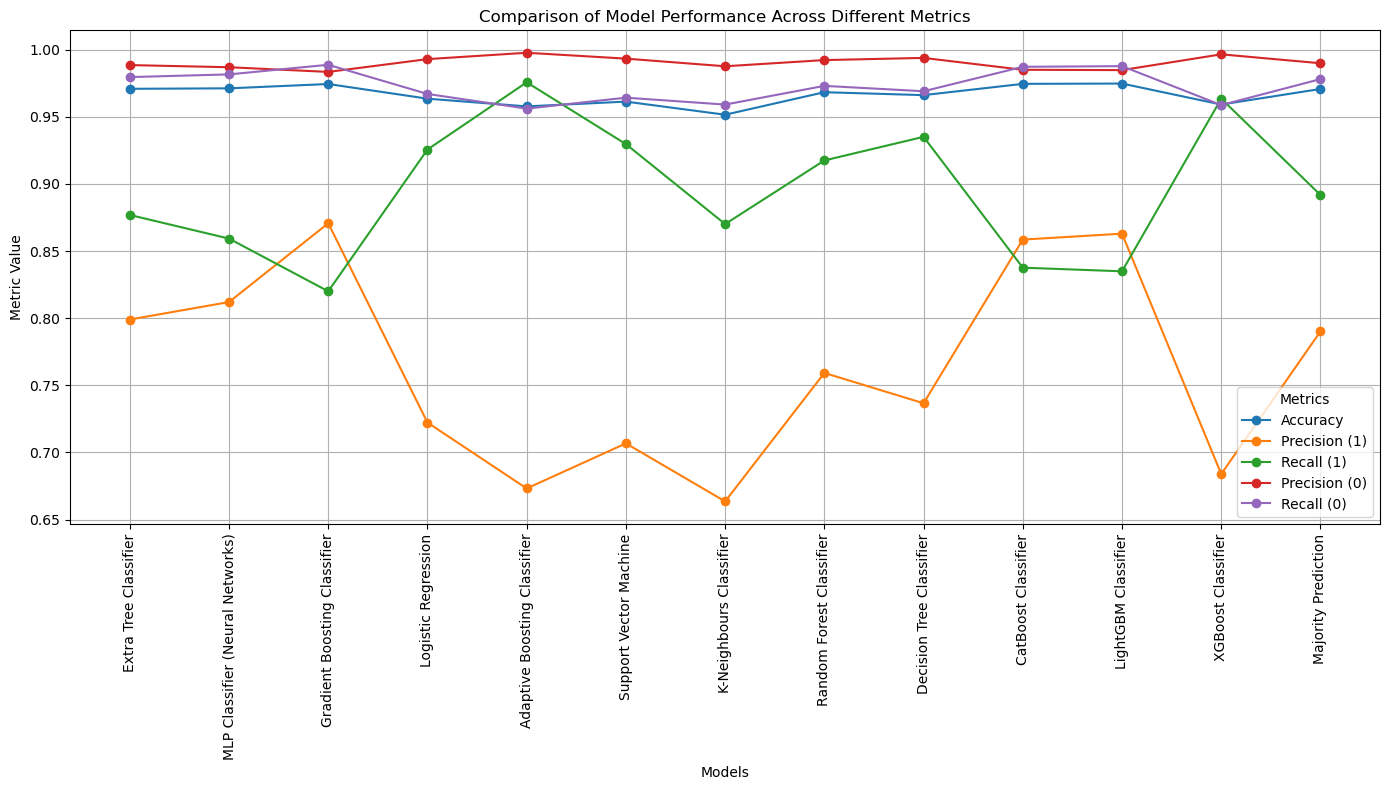

In [83]:
plt.figure(figsize=(14, 8))
metrics = ['Accuracy', 'Precision (1)', 'Recall (1)', 'Precision (0)', 'Recall (0)']
for metric in metrics:
    plt.plot(metrics_df['Model'], metrics_df[metric], marker='o', label=metric)

plt.xticks(rotation=90)
plt.xlabel('Models')
plt.ylabel('Metric Value')
plt.title('Comparison of Model Performance Across Different Metrics')
plt.grid(True)
plt.tight_layout()
plt.legend(title="Metrics", loc='lower right', frameon=True)
plt.show()

C:\Users\ayush\AppData\Local\Temp\ipykernel_15364\4244773115.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics_df["Model"]), y=list(metrics_df["Accuracy"]), palette='viridis')


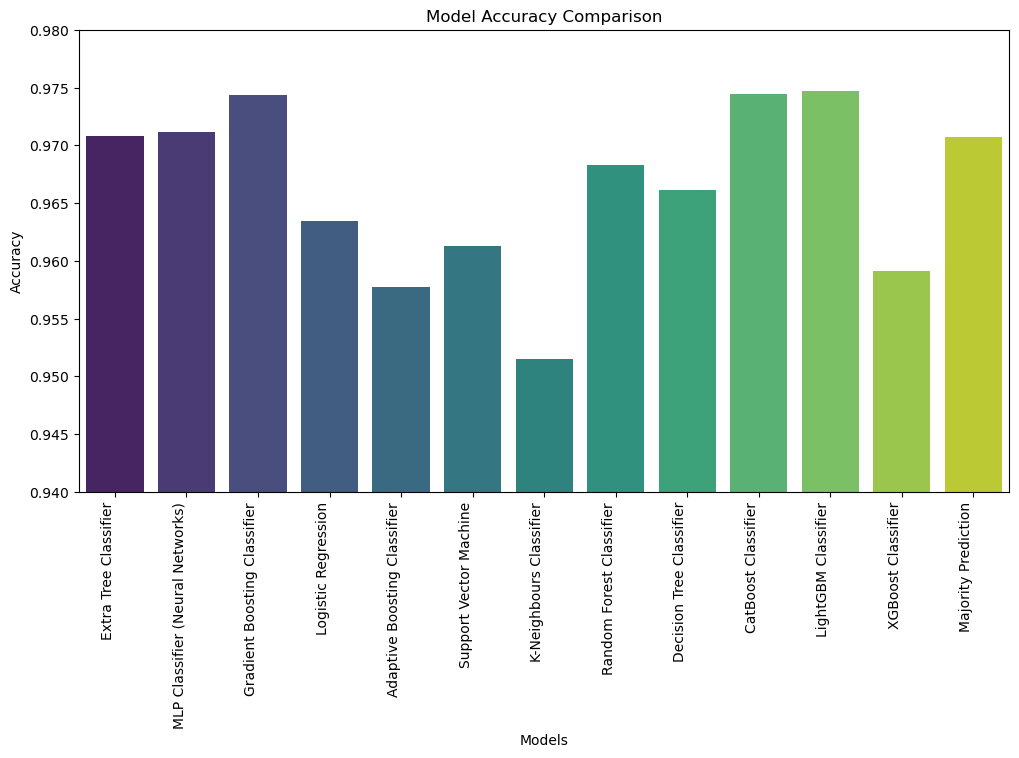

In [84]:
plt.figure(figsize=(12, 6))
sns.barplot(x=list(metrics_df["Model"]), y=list(metrics_df["Accuracy"]), palette='viridis')

plt.ylim(0.94, 0.98)
plt.xticks(rotation=90, ha='right')
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")

# Show the plot
plt.show()
